In [98]:
import os
import glob

import pandas as pd
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
print(torchvision.__version__)
#from torchvision.io import read_image


0.4.2


In [30]:
!cd /home/krom/projects/kaalge/easy_xray
!pwd
!ls 

/home/krom/projects/kaalge/easy_xray
bot.png			 dicom_metadata_train_merged.csv	  test
convert_dicom2jpg.ipynb  drive-download-20220526T181307Z-001.zip  train
cot.png			 lot.png				  train.csv
create_dataset.ipynb	 sample_submission.csv


In [108]:
train_df = pd.read_csv('train.csv')
train_metadata_df = pd.read_csv('dicom_metadata_train_merged.csv') # Took it from kaggle notebooks
#test_df = pd.read_csv('test.csv')
train_df #.iloc[0,0]
import os.path
files_path = glob.glob("**/*.jpg",recursive=True)

train_df['Target'].unique()
files_path
bone_files = [ f for f in files_path if f.endswith('bone.jpg')]
hsv_files = [ f for f in files_path if not f.endswith('bone.jpg')]
hsv_files[3],"\n",train_df.iloc[666,0]#,bone_files
#train_df.loc['1.2.826.0.1.3680043.8.498.33785782871926445035243454630719127502']

for f in bone_files:
    if train_metadata_df['SOPInstanceUID'].iloc[666] in f:
        print(f, "\n", train_metadata_df['SOPInstanceUID'].iloc[666])
train_metadata_df.head(8).columns[64:]
#y.append(np.ndarray.flatten(np.array(train_merged_df.loc[train_merged_df['SOPInstanceUID'] == uid][train_merged_df.columns[64:]])))
    

train/train/767/1.2.826.0.1.3680043.8.498.12415231198340152066958256836528342871/1.2.826.0.1.3680043.8.498.59250808142875182966287802312681142642/1.2.826.0.1.3680043.8.498.94213681653865343106015370701526119542-c.bone.jpg 
 1.2.826.0.1.3680043.8.498.94213681653865343106015370701526119542


Index(['Abdomen', 'Ankle', 'Cervical Spine', 'Chest', 'Clavicles', 'Elbow',
       'Feet', 'Finger', 'Forearm', 'Hand', 'Hip', 'Knee', 'Lower Leg',
       'Lumbar Spine', 'Others', 'Pelvis', 'Shoulder', 'Sinus', 'Skull',
       'Thigh', 'Thoracic Spine', 'Wrist'],
      dtype='object')

In [135]:
from torch.utils.data import Dataset
#from torchvision.io import read_image toooo old fot that stuff



class DicomDataset(Dataset):
    def __init__(self, merged_df, image_dir, bone = True, preload = True, transform=None, target_transform=None):
        self.img_labels = merged_df
        
        self.img_dir = image_dir
        self.transform = transform
        self.target_transform = target_transform
        self.files_path = glob.glob(image_dir+"/**/*.jpg",recursive=True)
        #print(len(self.img_labels), self.img_labels['SOPInstanceUID'])
        self.images = []
        self.file_pathes = []
        for im_num in range(len(self.img_labels)):
            item_name = self.img_labels['SOPInstanceUID'].iloc[im_num]
            #print(item_name)
            if bone:
                file_path = [ f for f in files_path if f.endswith(item_name + '-c.bone.jpg')]
            else:
                file_path = [ f for f in files_path if f.endswith(item_name + '-c.jpg')]
            self.file_pathes.append(file_path[0])
        #print(self.file_pathes)
        if preload:
            for img_path in self.file_pathes:
                
                #image = read_image(img_path) # my torch is too old. i'l use workaround
                image = Image.open(img_path)
                image = np.array(image).astype(np.uint8)
                self.images.append(image)
            self.preloaded = preload
        print(len(self.images))


    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        if self.preloaded:
            image = self.images[idx]
        else:
            image = read_image(self.file_pathes[idx])
        
        label = self.img_labels.iloc[idx, 64:]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


In [143]:
from torchvision.transforms import ToTensor, ToPILImage
training_data = DicomDataset(
    merged_df=train_metadata_df,
    image_dir="train",
#    train=True,
#    download=True,
    transform=ToTensor()
)



1738


In [144]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

train_size = int(0.8 * len(training_data))
test_size = len(training_data) - train_size
train_dataset, test_dataset = random_split(training_data, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [145]:
train_dataloader
len(training_data)

1738

torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])


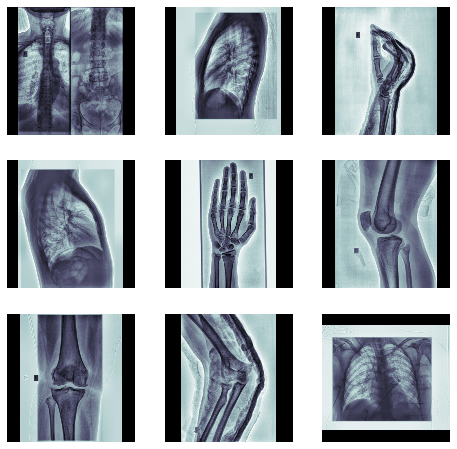

In [150]:
import torch as torch
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    print(img.shape)
    img = ToPILImage()(img.to('cpu'))
    figure.add_subplot(rows, cols, i)
    #plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()